# Bayesian Temporal Memory Tuning
This notebook focuses solely on Bayesian hyperparameter search with `gp_minimize` to tune the Temporal Memory + RDSE stack.
Adjust the settings in the final cell and rerun to explore different optimization budgets or stopping criteria.

In [1]:
import json
from dataclasses import asdict, dataclass
from pathlib import Path
from typing import Dict, List, Sequence

import numpy as np

from building_blocks import TemporalMemoryLayer
from rdse import RandomDistributedScalarEncoder as RDSE, RDSEParameters

try:  # Optional dependency for Bayesian optimization
    import skopt
    from skopt import gp_minimize
    from skopt.space import Integer, Real

    SKOPT_AVAILABLE = True
except ImportError:  # pragma: no cover - skopt not always installed
    skopt = None
    gp_minimize = None
    Integer = Real = None
    SKOPT_AVAILABLE = False

In [ ]:
@dataclass(frozen=True)
class SearchConfig:
    """Bundle all tunable knobs for evaluation."""

    segment_growth_speed: float
    learning_rate: float
    activation_threshold: int = 3
    learning_threshold: int = 9
    max_new_synapse_count: int = 16
    active_bits: int = 16
    resolution: float = 0.1
    cycle_length: int = 64
    rdse_seed: int = 3 

    num_columns: int = 1024
    cells_per_column: int = 4


if SKOPT_AVAILABLE:
    BAYES_SPACE = [
        Real(0.1, 1.0, name="segment_growth_speed"),
        Real(0.5, 5.0, name="learning_rate"),
    ]
else:
    BAYES_SPACE = None

In [3]:
def sine_cycle(cycle_length: int) -> np.ndarray:
    """Precompute one sine cycle to avoid recomputing each iteration."""
    return np.sin(np.linspace(0.0, 2.0 * np.pi, cycle_length, endpoint=False))


def encode_value(encoder: RDSE, value: float) -> List[int]:
    """Encode a scalar using the RDSE instance."""
    return encoder.encode(float(value))

In [4]:
def evaluate_config(
    cfg: SearchConfig,
    total_steps: int,
    evaluation_passes: int,
    rng_seed: int,
) -> dict:
    """Measure whether the configuration eliminates late bursting."""
    np.random.seed(rng_seed)
    tm = TemporalMemoryLayer(
        num_columns=cfg.num_columns,
        cells_per_column=cfg.cells_per_column,
        learning_rate=cfg.learning_rate,
        activation_threshold=cfg.activation_threshold,
        learning_threshold=cfg.learning_threshold,
        max_new_synapse_count=cfg.max_new_synapse_count,
        segment_growth_speed=cfg.segment_growth_speed,
    )

    rdse_params = RDSEParameters(
        size=cfg.num_columns,
        active_bits=cfg.active_bits,
        sparsity=0.0,
        radius=0.0,
        resolution=cfg.resolution,
        category=False,
        seed=cfg.rdse_seed,
    )
    encoder = RDSE(rdse_params)
    sine_values = sine_cycle(cfg.cycle_length)

    burst_counts: List[int] = []
    for step in range(total_steps):
        value = sine_values[step % cfg.cycle_length]
        encoded_bits = encode_value(encoder, value)
        active_columns = {idx for idx, bit in enumerate(encoded_bits) if bit}
        tm.set_active_columns(active_columns)
        tm.compute(learn=True)
        burst_counts.append(len(tm.bursting_columns))

    evaluation_bursts: List[int] = []
    for step in range(evaluation_passes):
        value = sine_values[step % cfg.cycle_length]
        encoded_bits = encode_value(encoder, value)
        active_columns = {idx for idx, bit in enumerate(encoded_bits) if bit}
        tm.set_active_columns(active_columns)
        tm.compute(learn=False)
        evaluation_bursts.append(len(tm.bursting_columns))

    max_initial = max(burst_counts[: min(10, len(burst_counts))])
    final_burst = burst_counts[-1]
    steady_state_clear = all(count == 0 for count in evaluation_bursts[1:])

    metrics = {
        "max_initial_bursts": int(max_initial),
        "final_burst": int(final_burst),
        "evaluation_burst_sum": int(sum(evaluation_bursts[1:])),
        "passes": max_initial > 0 and final_burst == 0 and steady_state_clear,
    }
    penalty = 0 if metrics["passes"] else 1
    metrics["score"] = (
        final_burst * 1_000
        + metrics["evaluation_burst_sum"] * 10
        + (0 if max_initial > 0 else 100_000)
        + penalty * 500_000
    )
    return metrics

In [5]:
def vector_to_config(vector: Sequence[float]) -> SearchConfig:
    """Convert optimizer suggestions into a SearchConfig."""
    return SearchConfig(
        activation_threshold=int(vector[0]),
        learning_threshold=int(vector[1]),
        segment_growth_speed=float(vector[2]),
        learning_rate=float(vector[3]),
    )


def summarize_parameter_trends(results: List[dict]) -> Dict[str, Dict[str, dict]]:
    """Aggregate mean scores per parameter value to find trends."""
    aggregates: Dict[str, Dict[str, List[int]]] = {}
    for trial in results:
        score = trial["metrics"]["score"]
        for key, value in trial["config"].items():
            aggregates.setdefault(key, {})
            aggregates[key].setdefault(str(value), []).append(score)

    summary: Dict[str, Dict[str, dict]] = {}
    for key, value_map in aggregates.items():
        summary[key] = {}
        for value, scores in value_map.items():
            summary[key][value] = {
                "mean_score": float(np.mean(scores)),
                "samples": len(scores),
            }
    return summary


def log_trial(idx: int, metrics: dict) -> None:
    """Pretty-print trial progress."""
    print(
        f"Trial {idx:03d}: score={metrics['score']:,} "
        f"passes={metrics['passes']} final={metrics['final_burst']}"
    )

In [6]:
def run_gp_optimization(
    total_steps: int = 1000,
    evaluation_passes: int = 64,
    max_trials: int = 30,
    rng_seed: int = 42,
    shuffle_seed: int = 0,
    stop_on_success: bool = True,
 ):
    """Run gp_minimize-driven Bayesian optimization over the TM search space."""
    if not SKOPT_AVAILABLE or gp_minimize is None or BAYES_SPACE is None:
        raise RuntimeError(
            "scikit-optimize is required for this workflow. Install it before running."
        )

    trial_records: List[dict] = []

    def objective(vector: Sequence[float]) -> float:
        cfg = vector_to_config(vector)
        metrics = evaluate_config(cfg, total_steps, evaluation_passes, rng_seed)
        log_trial(len(trial_records) + 1, metrics)
        trial_records.append({"config": asdict(cfg), "metrics": metrics})
        return metrics["score"]

    callbacks = []
    if stop_on_success:

        def stopper(_: "skopt.OptimizeResult") -> bool:
            return bool(trial_records and trial_records[-1]["metrics"]["passes"])

        callbacks.append(stopper)

    minimize_kwargs = {
        "func": objective,
        "dimensions": BAYES_SPACE,
        "n_calls": max_trials,
        "random_state": shuffle_seed,
        "acq_func": "EI",
        "n_initial_points": min(10, max_trials),
    }

    if callbacks:
        minimize_kwargs["callback"] = callbacks

    result = gp_minimize(**minimize_kwargs)
    return trial_records, result

In [11]:
output_path = Path("hyperparam_search_results.json")
optimization_settings = {
    "total_steps": 1000,
    "evaluation_passes": 64,
    "max_trials": 100,
    "rng_seed": 42,
    "shuffle_seed": 0,
    "stop_on_success": False,
}

trials, gp_result = run_gp_optimization(**optimization_settings)
if not trials:
    raise RuntimeError("No trials executed; increase max_trials or relax the search space.")

best_result = min(trials, key=lambda trial: trial["metrics"]["score"])
trends = summarize_parameter_trends(trials)
summary = {
    "trials": len(trials),
    "best_score": best_result["metrics"]["score"],
    "passes": best_result["metrics"]["passes"],
    "settings": optimization_settings,
}
payload = {
    "summary": summary,
    "results": trials,
    "parameter_trends": trends,
}
output_path.write_text(json.dumps(payload, indent=2))

print("Best configuration:")
print(json.dumps(best_result, indent=2))
print("\nParameter trends written to", output_path)


Trial 001: score=0 passes=True final=0
Trial 002: score=526,080 passes=False final=16
Trial 003: score=0 passes=True final=0
Trial 004: score=526,080 passes=False final=16
Trial 005: score=526,080 passes=False final=16
Trial 006: score=0 passes=True final=0
Trial 007: score=0 passes=True final=0
Trial 008: score=526,080 passes=False final=16
Trial 009: score=500,030 passes=False final=0
Trial 010: score=0 passes=True final=0
Trial 011: score=526,080 passes=False final=16
Trial 012: score=0 passes=True final=0
Trial 013: score=508,220 passes=False final=6
Trial 014: score=0 passes=True final=0
Trial 015: score=0 passes=True final=0
Trial 016: score=0 passes=True final=0
Trial 017: score=0 passes=True final=0
Trial 018: score=500,020 passes=False final=0
Trial 019: score=500,010 passes=False final=0
Trial 020: score=500,010 passes=False final=0
Trial 021: score=0 passes=True final=0
Trial 022: score=0 passes=True final=0
Trial 023: score=526,080 passes=False final=16
Trial 024: score=0 p

<Axes: >

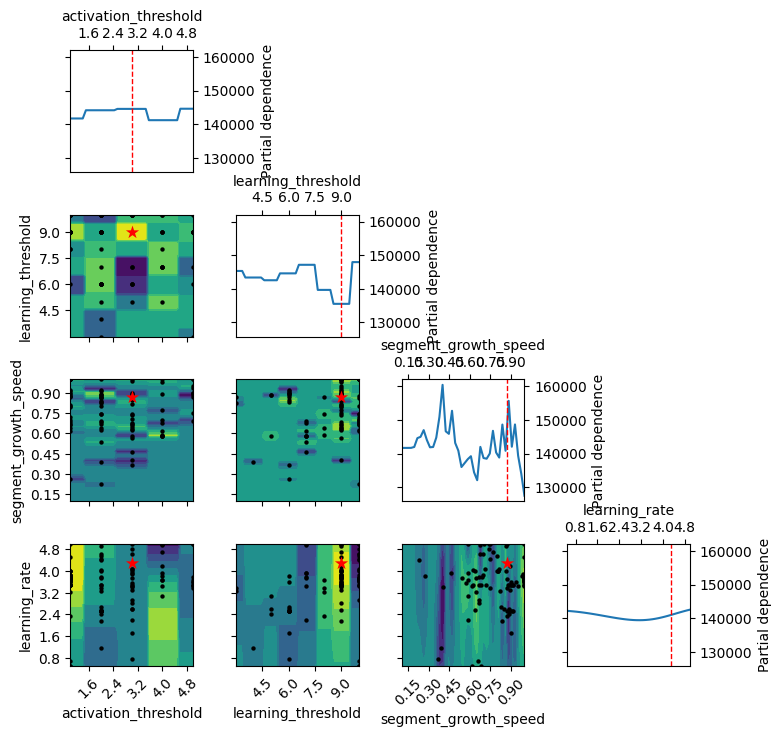

In [12]:
from skopt import plots
plots.plot_objective(gp_result)

## How To Use
1. Adjust `optimization_settings` in the last cell to control the search budget or seeding.
2. Run that cell to launch Bayesian optimization and persist the JSON summary to `hyperparam_search_results.json`.
3. Inspect the printed best configuration or open the saved JSON for the full trial history.